In [12]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
#plt.rcParams['text.usetex'] = True
# plt.style.use(['dark_background'])
# plt.style.use('classic')
%matplotlib inline
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [98]:
winsize = "3mb"
wdir = "./"
chess_results_file = "ukm_chr2_{}_control_vs_patient_chess_results.tsv".format(winsize)

region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

similarities = pd.read_csv(wdir + chess_results_file, sep='\t', index_col=0)
regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

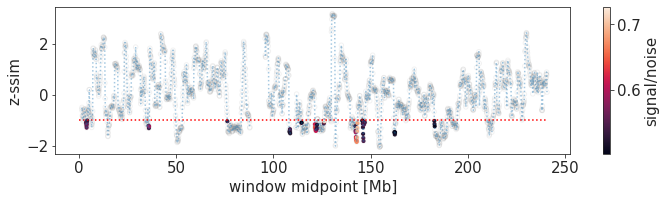

In [114]:
sim_field = "z_ssim"
sn_thr = 0.5
zsim_thr = -1
sub_sim = similarities[(similarities["SN"]>= sn_thr) & (similarities[sim_field]<= zsim_thr)]

all_X = regions.loc[similarities.index, 1:2].mean(axis=1).values / 10 ** 6
X = regions.loc[sub_sim.index, 1:2].mean(axis=1).values / 10 ** 6
S = sub_sim[sim_field]
SN = sub_sim["SN"]
plt.figure(figsize=(10, 3))
plt.plot(all_X, similarities[sim_field], ":", alpha=0.4)
plt.hlines(zsim_thr, 0, max(all_X), linestyle=":", color="red")
plt.scatter(all_X, similarities[sim_field], facecolors='none', edgecolors='grey', alpha=0.1, s=20)
plt.scatter(X, S, c=SN, marker='.')
plt.ylabel(sim_field.replace("_", "-"))
plt.xlabel("window midpoint [Mb]")
c = plt.colorbar()
c.set_label("signal/noise")
plt.tight_layout()
plt.savefig("../../docs/plots/chr2_{}_results_track.png".format(winsize), dpi=250)

In [110]:
similarities[(similarities["SN"]>= sn_thr)].sort_values("z_ssim")

,SN,ssim,z_ssim
ID,,,
1413,0.669822,0.150431,-1.848136
1448,0.546223,0.154552,-1.814770
1412,0.658881,0.154610,-1.814298
1411,0.639182,0.159327,-1.776110
1447,0.542377,0.169218,-1.696021
...,...,...,...
407,0.878188,0.671197,2.368506
2287,0.801535,0.672898,2.382272
406,0.888130,0.674134,2.392280


In [8]:
patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

chr2:144800001-147800001


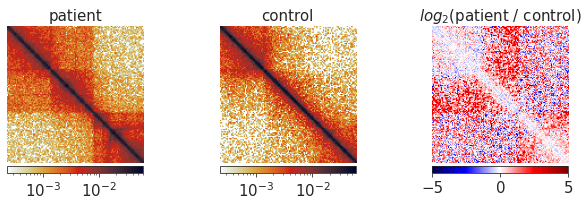

In [111]:
region_id = 1448

window_start, window_end = regions.loc[region_id][1:3]

region_string = "chr2:{}-{}".format(window_start, window_end)
print(region_string)

patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v

l2fcm = np.log2(patient_region_sub / control_region_sub)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].set_title('patient')
axes[1].set_title('control')
axes[2].set_title('$log_2$(patient / control)')

m1 = axes[0].imshow(patient_region_sub, norm=matplotlib.colors.LogNorm(), cmap='germany')
m2 = axes[1].imshow(control_region_sub, norm=matplotlib.colors.LogNorm(), cmap='germany')
m3 = axes[2].imshow(l2fcm, cmap='seismic', vmax=5, vmin=-5)
for m, ax in zip([m1, m2, m3], axes):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    fig.colorbar(m, cax=cax, orientation='horizontal')

plt.tight_layout()
plt.savefig("../../docs/plots/chr2_example_region.png", dpi=250)

# Feature extraction

In [112]:
## obtaining regions of interest
regions2compare = regions.loc[sub_sim.index]
regions2compare.to_csv('filtered_regions_chr2_{}_100kb.tsv'.format(winsize), '\t', index=False, header=False)

## Check 2 examples

In [115]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def highlight_features(dataframe, region, color, a, axes):
    try:
        features = dataframe.loc[region].values.tolist()
        if type(features[0]) == int:
            _, x_min, x_max, y_min, y_max = features
            rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                     edgecolor=color, facecolor='none')
            axes[a].add_patch(rect)
        else:
            for f in features:
                _, x_min, x_max, y_min, y_max = f
                rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                         edgecolor=color, facecolor='none')
                axes[a].add_patch(rect)
                
    except KeyError:
        next

In [119]:
## load gained and lost features
gained = pd.read_csv(wdir + 'features/gained_features.tsv', delimiter=',', usecols=[0, 1, 2, 3,4, 5], header=None, index_col=[0])
lost = pd.read_csv(wdir + 'features/lost_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])

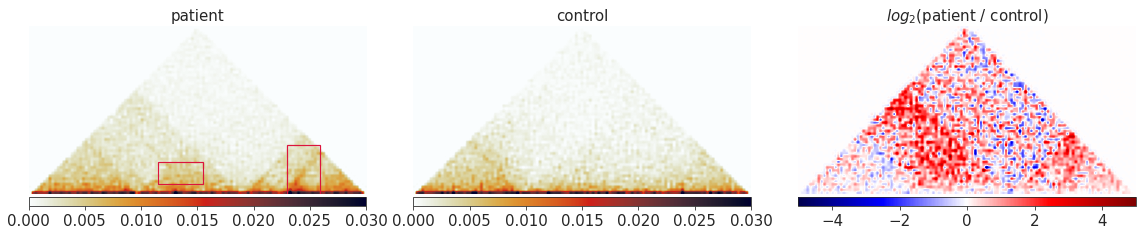

In [121]:
reg = 1448

window_start, window_end = regions.loc[reg][1:3]

# margin = 2 * 10 ** 6
# window_start = int(window_start - margin)
# window_end = int(window_end + margin)

region_string = "chr2:{}-{}".format(window_start, window_end)
# region_string = "chr2:{}-{}".format(int(window_start), int(window_end))
# print(region_string)

# import fanc
patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v

l2fcm = np.log2(patient_region_sub / control_region_sub)
zml2 = clipped_zoom(l2fcm, 0.7)
rot_l2 = ndi.rotate(zml2, 45, reshape=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

axes[0].set_title('patient')
axes[1].set_title('control')
axes[2].set_title('$log_2$(patient / control)')

# clipped zoom and rotate patient and control and keep only half-matrix
zm1 = clipped_zoom(control_region_sub, 0.7)
rot_control = ndi.rotate(zm1, 45, reshape=False)

zm2 = clipped_zoom(patient_region_sub, 0.7)
rot_patient = ndi.rotate(zm2, 45, reshape=False)

middle = int(np.shape(rot_control)[1]/ 2.)

m1 = axes[0].imshow(rot_patient[:middle, :], vmin=0, vmax=0.03, cmap='germany')
m2 = axes[1].imshow(rot_control[:middle,:], vmin=0, vmax=0.03, cmap='germany')

# per region check if identified features, to highlight
highlight_features(gained, reg, 'crimson', 0, axes)
highlight_features(lost, reg, 'royalblue', 1, axes)

m3 = axes[2].imshow(rot_l2[:middle,:], cmap='seismic', vmax=5, vmin=-5)


for m, ax in zip([m1, m2, m3], axes):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    fig.colorbar(m, cax=cax, orientation='horizontal')

plt.tight_layout()
plt.savefig("../../docs/plots/chr2_example_region_with_features.png", dpi=250)